In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read the dataset from CSV File
data = pd.read_csv('data.csv')
data.head(5)

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
#Dividing dataset into features and result
#Put Features into X
X = data[['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos']]
print(X.shape)
X.head(5)

#Hot Encoding
X_hot = pd.get_dummies(X, columns=['location', 'country','gender', 'age', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos'])
print(X_hot.shape)
print(X_hot.head(5))

(863, 13)
(863, 373)
   vis_wuhan  from_wuhan  ...  diff_sym_hos_14  diff_sym_hos_15
0          1           0  ...                0                0
1          0           1  ...                0                0
2          0           1  ...                0                0
3          1           0  ...                0                0
4          0           0  ...                0                0

[5 rows x 373 columns]


In [4]:
#Labeled Data
Y = data['result']
print(Y.shape)
Y.head()

(863,)


0    1
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [5]:
#splite the data into Train and Test by 84% for training to 16% for testing
xTrain, xTest, yTrain, yTest = train_test_split(X_hot, Y, test_size = .16, random_state = 3, shuffle = True)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(724, 373)
(139, 373)
(724,)
(139,)


In [6]:
#normalize the data values
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain=scaler.transform(xTrain)
xTest=scaler.transform(xTest)

In [7]:
#GrideSearchCV to find the optimal hyperparameters by fit alot of models with difrrent hyperparameters and chose the best one with high accuracy
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'], 'C':[0.001,.009,0.01,.09,1,5,10,25, 1e5], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,  cv= 10 , n_jobs= -1,scoring = 'accuracy')
grid_clf_acc.fit(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25,
                               100000.0],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [8]:
print(grid_clf_acc.best_score_)
print(grid_clf_acc.best_params_)
print(grid_clf_acc.best_estimator_)

0.9448249619482496
{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1, solver='newton-cg')


In [9]:
#train the model with optimal hyperparameters
LogisticRegressionModel = LogisticRegression(penalty = 'l2', solver = 'newton-cg', C = 1, random_state=3, max_iter = 500)
LogisticRegressionModel.fit(xTrain, yTrain)

LogisticRegression(C=1, max_iter=500, random_state=3, solver='newton-cg')

In [10]:
#test the accuracy of model on training set
print('LogisticRegressionModel Train Score is : ' , LogisticRegressionModel.score(xTrain, yTrain))
print('----------------------------------------------------')


LogisticRegressionModel Train Score is :  1.0
----------------------------------------------------


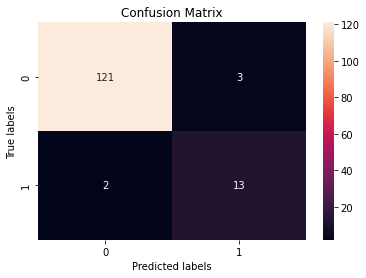

In [11]:
#Calculating Prediction
yPred = LogisticRegressionModel.predict(xTest)

#----------------------------------------------------
#Calculating Confusion Matrix
CM = confusion_matrix(yTest, yPred)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [12]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(yTest, yPred)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.81      0.87      0.84        15

    accuracy                           0.96       139
   macro avg       0.90      0.92      0.91       139
weighted avg       0.97      0.96      0.96       139



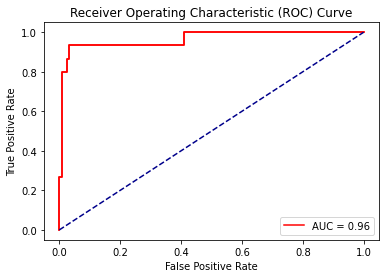

In [13]:
#Calculating Area Under the Curve with predict probapility:
fpr, tpr, thresholds = roc_curve(yTest, LogisticRegressionModel.predict_proba(xTest)[:,1])

roc_auc = roc_auc_score(yTest, LogisticRegressionModel.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')